Documentagion: https://github.com/slundberg/shap

RF Example: https://www.kaggle.com/dansbecker/shap-values/data

SHAP Values: https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap, math

# Data Import & Process

In [2]:
data = pd.read_csv('BlackFriday.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [4]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
np.sort(data.Product_Category_2.unique())

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., nan])

In [6]:
np.sort(data.Product_Category_3.unique())

array([ 3.,  4.,  5.,  6.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., nan])

In [7]:
df = data.fillna(0).copy()

In [8]:
cat_cols = df.select_dtypes('object').columns
df[cat_cols] = df[cat_cols].apply(lambda x:x.astype('category').cat.codes)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null int16
Gender                        537577 non-null int8
Age                           537577 non-null int8
Occupation                    537577 non-null int64
City_Category                 537577 non-null int8
Stay_In_Current_City_Years    537577 non-null int8
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            537577 non-null float64
Product_Category_3            537577 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int16(1), int64(5), int8(4)
memory usage: 31.8 MB


In [10]:
df.Purchase.mean()

9333.859852635065

In [11]:
df['above_avg'] = np.where(df['Purchase']>=9333, 1, 0)

In [12]:
y = df['above_avg']
X = df.drop(['above_avg','Purchase'],axis=1).copy()

In [13]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Instantiate and Train Model

In [14]:
%time my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

CPU times: user 12.6 s, sys: 310 ms, total: 12.9 s
Wall time: 10.4 s


In [15]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    train_err = rmse(m.predict(train_X), train_y)
    train_score = m.score(train_X, train_y)
    test_err = rmse(m.predict(val_X), val_y)
    test_score =  m.score(val_X, val_y)
    print('Train RMSE: {}, Train Accuracy: {}'.format(train_err,train_score))
    print('Validation RMSE: {}, Validation Accuracy: {}'.format(test_err,test_score))
    if hasattr(m, 'oob_score_'):
        print('OOB Score: {}'.format(m.oob_score_))

In [16]:
print_score(my_model)

Train RMSE: 0.09666010057172825, Train Accuracy: 0.9906568249574634
Validation RMSE: 0.38002312437349905, Validation Accuracy: 0.855582424941404


In [17]:
single_prediction = val_X.iloc[5,:].values.reshape(1,-1)
single_prediction

array([[1.004808e+06, 3.100000e+01, 1.000000e+00, 3.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 1.000000e+00,
        8.000000e+00, 1.500000e+01, 0.000000e+00]])

In [18]:
my_model.predict_proba(single_prediction)

array([[0.8, 0.2]])

# Instantiate Explainer

In [19]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

## Single Predictions

In [20]:
%time shap_values = explainer.shap_values(single_prediction)

CPU times: user 463 ms, sys: 2.96 ms, total: 466 ms
Wall time: 467 ms


In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], val_X.iloc[5,:])

## Various Predictions

In [22]:
%time shap_values = explainer.shap_values(val_X.iloc[:1000,:])

CPU times: user 7min 45s, sys: 4.29 s, total: 7min 50s
Wall time: 7min 52s


In [23]:
shap.force_plot(explainer.expected_value[1], shap_values[1], val_X.iloc[:1000,:])

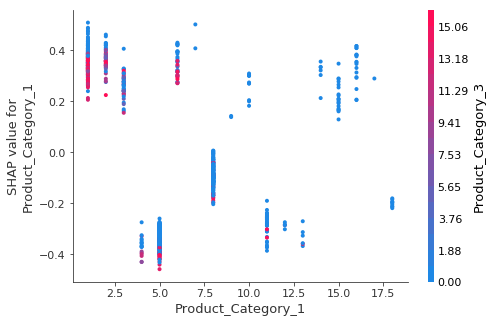

In [24]:
shap.dependence_plot("Product_Category_1",shap_values[1],val_X.iloc[:1000,:])

In [25]:
import matplotlib.pyplot as plt

def feature_means(df,feature,label):
    means = {}
    vals = np.sort(df[feature].unique())
    for val in vals:
        val_mean = df[df[feature] == val][label].mean()
        means[val]=val_mean
    
    fig = plt.figure()
    x = np.linspace(1,len(means),len(means))
    plt.bar(means.keys(),means.values())
    plt.xticks(x)
    plt.show()

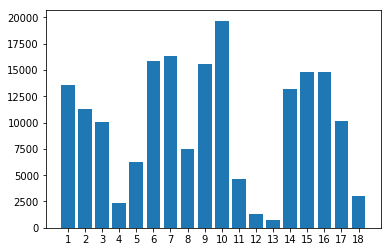

In [26]:
feature_means(df,'Product_Category_1','Purchase')

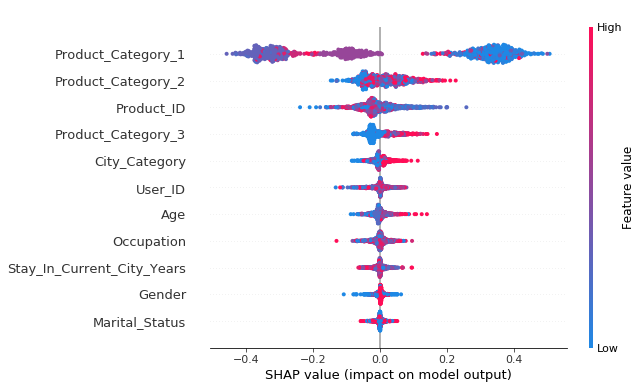

In [27]:
shap.summary_plot(shap_values[1],val_X.iloc[:1000,:])

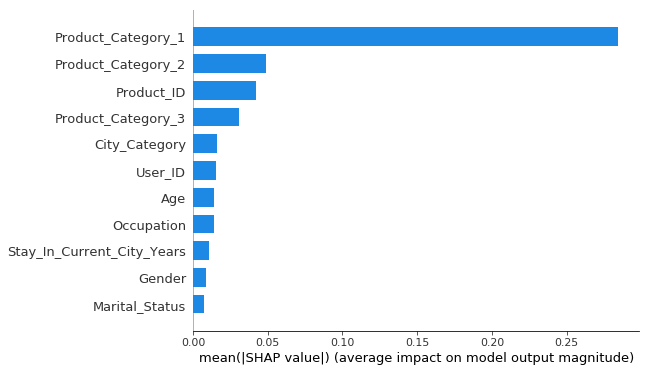

In [28]:
shap.summary_plot(shap_values[1],val_X.iloc[:1000,:],plot_type="bar")